In [1]:
import glob
import cv2
import os
images_t = glob.glob("RiceLeafDisease//b150//JPEGImages//*.jpg")
images_t.sort()
masks_t = glob.glob("RiceLeafDisease//b150//SegmentationClass//*.png")
masks_t.sort()
print(len(images_t))
print(len(masks_t))

150
150


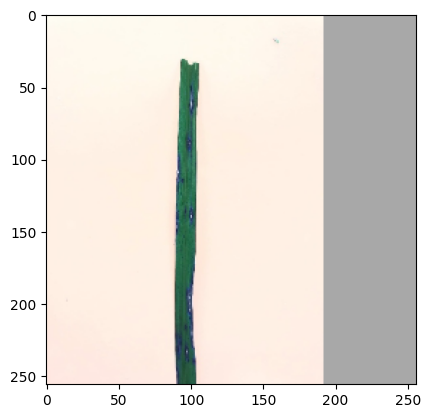

In [2]:
import os
import matplotlib.pyplot as plt
image_t=[]
mask_t=[]
for x in images_t:
  im=cv2.imread(str(x),cv2.IMREAD_COLOR)
  im=cv2.resize(im,(256,256))
  image_t.append(im)
  plt.imshow(im)

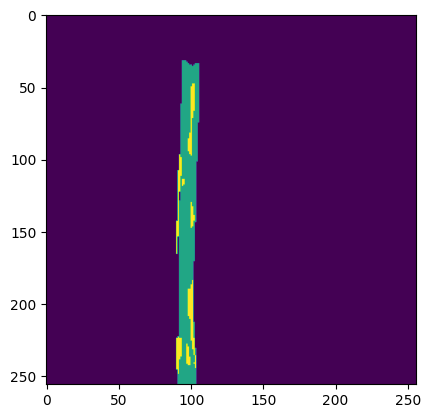

In [3]:
for y in masks_t:
  ma=cv2.imread(str(y),cv2.IMREAD_GRAYSCALE)
  ma=cv2.resize(ma,(256,256),interpolation = cv2.INTER_NEAREST)
  plt.imshow(ma)
  mask_t.append(ma)

In [4]:
import numpy as np
img_array_t=np.array(image_t)
mask_array_t=np.array(mask_t)
mask_array_t=np.expand_dims(mask_array_t,axis=-1)
mask_array_t=mask_array_t.astype(np.float32)
print(img_array_t.shape)
print(mask_array_t.shape)
print((np.unique(mask_array_t)))
print(mask_array_t.shape)

(150, 256, 256, 3)
(150, 256, 256, 1)
[  0. 106. 179.]
(150, 256, 256, 1)


In [5]:
s=np.unique(mask_array_t)
s

array([  0., 106., 179.], dtype=float32)

In [6]:
for i in s[1:]:
    a=np.where(mask_array_t==i)
    mask_array_t[a]=1

In [7]:
print(np.unique(mask_array_t))

[0. 1.]


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(img_array_t,mask_array_t,test_size=0.2,random_state=10)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(64, (3, 3), padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same')(p3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)
    
    # Bridge
    b1 = layers.Conv2D(1024, (3, 3), padding='same')(p4)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(1024, (3, 3), padding='same')(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    
    # Decoder
    d1 = layers.Conv2DTranspose(512, (2, 2), strides=2, padding='same')(b1)
    d1 = layers.Concatenate()([d1, x4])
    d1 = layers.Conv2D(512, (3, 3), padding='same')(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)
    d1 = layers.Conv2D(512, (3, 3), padding='same')(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)
    
    d2 = layers.Conv2DTranspose(256, (2, 2), strides=2, padding='same')(d1)
    d2 = layers.Concatenate()([d2, x3])
    d2 = layers.Conv2D(256, (3, 3), padding='same')(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)
    d2 = layers.Conv2D(256, (3, 3), padding='same')(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)
    
    d3 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same')(d2)
    d3 = layers.Concatenate()([d3, x2])
    d3 = layers.Conv2D(128, (3, 3), padding='same')(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)
    d3 = layers.Conv2D(128, (3, 3), padding='same')(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)
    
    d4 = layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same')(d3)
    d4 = layers.Concatenate()([d4, x1])
    d4 = layers.Conv2D(64, (3, 3), padding='same')(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)
    d4 = layers.Conv2D(64, (3, 3), padding='same')(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    
    model = Model(inputs, outputs, name='U-Net')
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [10]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming img_array_t and mask_array_t are your training data
history = model.fit(X_train, 
                    Y_train,
                    batch_size=1,
                    epochs=10,
                    steps_per_epoch=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - accuracy: 0.4904 - loss: 0.8924
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.7836 - loss: 0.5246
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.7674 - loss: 0.5615
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.9197 - loss: 0.3496
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.8850 - loss: 0.3042
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.9072 - loss: 0.2682
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.8288 - loss: 0.3889
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.9261 - loss: 0.2812
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.9084 - loss: 0.3135
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.9834 - loss: 0.1530


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


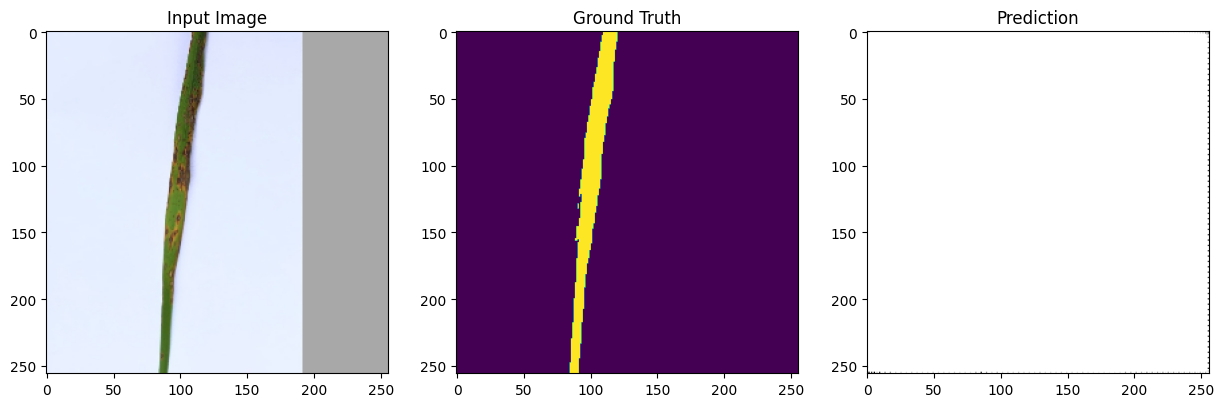

In [12]:
predictions = model.predict(X_test)

index = 0  # change index to visualize different samples

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(X_test[index], cv2.COLOR_BGR2RGB))
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(Y_test[index].squeeze())
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(),cmap='gray')
plt.title('Prediction')

plt.show()

In [15]:
model.evaluate(X_test,Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.2126 - loss: 140.1707


[140.17066955566406, 0.2125503569841385]